### Global Model: Support being trained on multiple time series (sometimes referred as meta learning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 370 kB 15.1 MB/s 
     |████████████████████████████████| 65 kB 4.7 MB/s 
     |████████████████████████████████| 11.2 MB 64.5 MB/s 
     |████████████████████████████████| 585 kB 64.8 MB/s 
     |████████████████████████████████| 179 kB 77.2 MB/s 
     |████████████████████████████████| 793 kB 65.3 MB/s 
     |████████████████████████████████| 9.8 MB 63.2 MB/s 
     |████████████████████████████████| 1.4 MB 63.7 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 381 kB 64.5 MB/s 
     |████████████████████████████████| 930 kB 61.9 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
     |████████████████████████████████| 596 kB 56.4 MB/s 
     |████████████████████████████████| 418 kB 75.3 MB/s 
     |████████████████████████████████

In [ ]:
pip install pyyaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 636 kB 14.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 15.1 MB/s 
     |████████████████████████████████| 209 kB 70.3 MB/s 
     |████████████████████████████████| 81 kB 11.1 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 112 kB 65.1 MB/s 
     |████████████████████████████████| 146 kB 60.2 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=d77173959c0363bc3f9adfd154d95f7d67990ffa52b9c302e2d5bae534b4116b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 13.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.0 requires matplotlib>=3.3, but you have matplotlib 3.1.1 which is incompatible.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
darts 0.19.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape, smape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
import warnings
warnings.filterwarnings('ignore')
import logging

logging.disable(logging.CRITICAL)

import os
import pickle
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch.nn.functional as F
import optuna
import joblib

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
with open('/content/drive/MyDrive/교육/AI실무인증과정/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)
    
BTT = data['KRW-BTC']
# ETH = data['KRW-BTC'][['candle_date_time_kst', 'trade_price']]

In [ ]:
cols = ['candle_date_time_kst', 'opening_price', 'high_price', 'low_price', 
        'trade_price', 'candle_acc_trade_price', 'candle_acc_trade_volume', 
        'prev_closing_price', 'change_price', 'change_rate', 'MA5', 'MA20', 'MA60']
coin = data['KRW-BTC']
coin.set_index(pd.to_datetime(coin['candle_date_time_kst']), inplace = True)
coin = coin.drop(columns = ['candle_date_time_kst'])
coin = coin[~coin.index.duplicated(keep = 'first')]
series = TimeSeries.from_dataframe(coin,  value_cols = cols[1:], fill_missing_dates=True, freq=None)

In [ ]:
# Create training and validation sets:
training_cutoff = pd.Timestamp("20220101")
train, val = series.split_after(training_cutoff)

In [ ]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

### TFT with Basic Covariates

In [ ]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)

In [ ]:
covariates = covariates.astype(np.float32)

In [ ]:
# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [ ]:
# default quantiles for QuantileRegression
# quantiles = [0.01] + [round(x, 2) for x in list(np.linspace(0, 1, 21)[1:-1])] + [.99]
def train_model(trial): 
  cfg = {'hidden_size' : trial.suggest_categorical('hidden_size', [16,32,64,128,256,512,1024]),
         'lstm_layers' : trial.suggest_int('lstm_layers', 1, 10, 1),
         'num_attention_heads' : trial.suggest_int('num_attention_heads', 4, 20, 2),
         'dropout' : trial.suggest_uniform('dropout', 0.1, 0.5),
         'batch_size' : trial.suggest_categorical('batch_size', [16,32,64,128,256,512,1024]),          
         'n_epochs' : trial.suggest_int('n_epochs', 10, 100, 10)} 

  quantiles = [.01, .05, .5, .95, .99]
  input_chunk_length = 24
  forecast_horizon = 12
  my_model = TFTModel(
      input_chunk_length=input_chunk_length,
      output_chunk_length=forecast_horizon,
      hidden_size=cfg['hidden_size'],
      lstm_layers=cfg['lstm_layers'],
      num_attention_heads=cfg['num_attention_heads'],
      dropout=cfg['dropout'],
      batch_size=cfg['batch_size'],
      n_epochs=cfg['n_epochs'],
      add_relative_index=False,
      add_encoders=None,
      likelihood=QuantileRegression(
          quantiles=quantiles
      ),  # QuantileRegression is set per default
      # loss_fn=MSELoss(),
      random_state=42,
  )

  my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)  

  num_samples = 200
  figsize = (20, 7)
  lowest_q, low_q, high_q, highest_q = .01, .1, .9, .99

  label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
  label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

  def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend(bbox_to_anchor=(1.05, 1))

  n = 24
  eval_model(my_model, n, series_transformed, val_transformed)

  val_series = val_transformed
  pred_series = my_model.predict(n=n, num_samples=num_samples)
  SMAPE = smape(val_series, pred_series)

  return SMAPE

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

['/content/drive/MyDrive/교육/AI실무인증과정/DeepAR/darts-TFT_optuna_01.pkl']

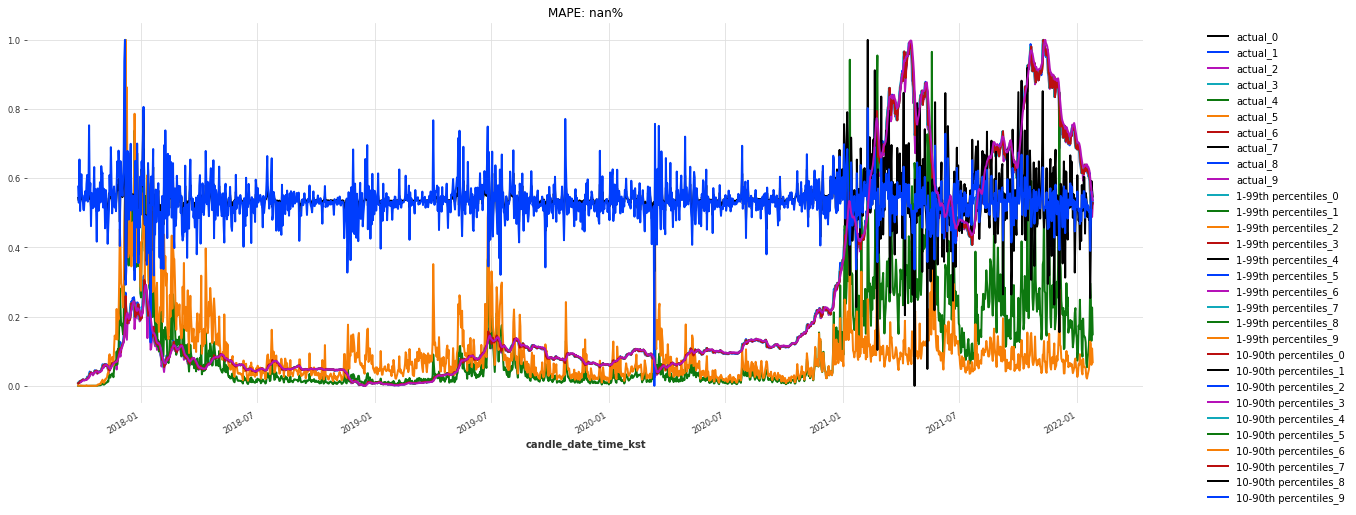

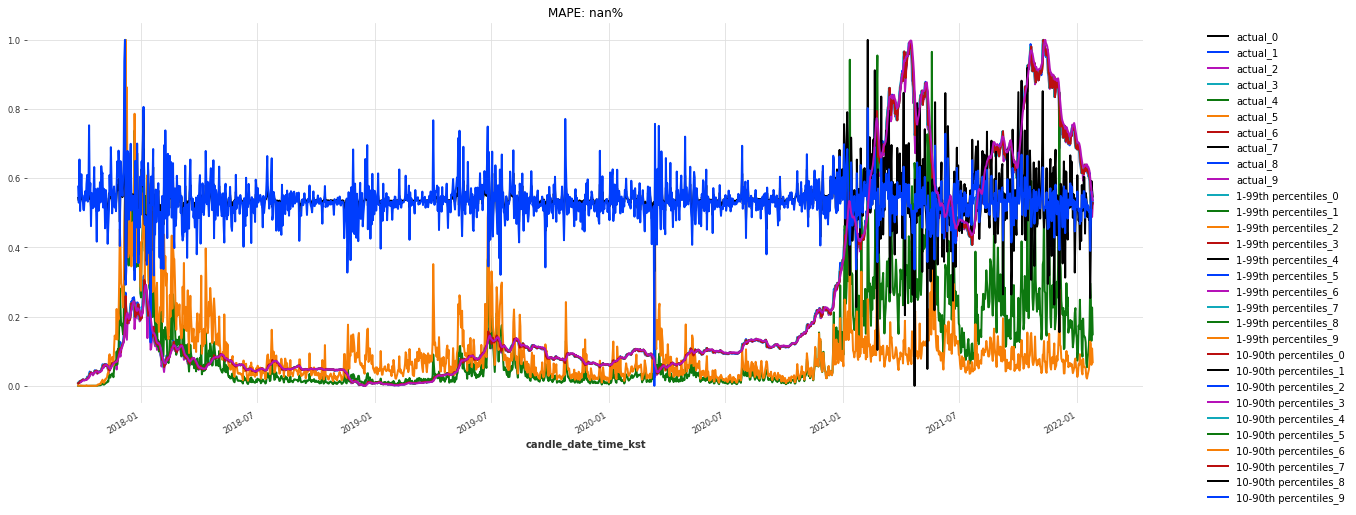

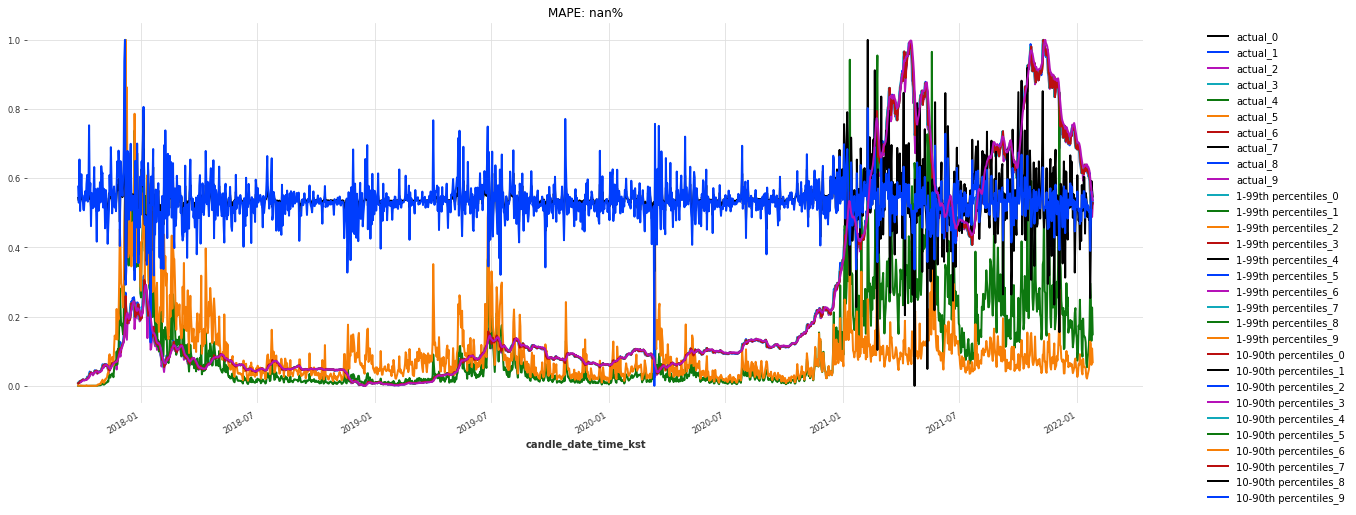

In [ ]:
sampler = optuna.samplers.TPESampler() 

study = optuna.create_study(sampler=sampler, direction='minimize') 
study.optimize(train_model, n_trials=3) 
joblib.dump(study, '/content/drive/MyDrive/교육/AI실무인증과정/DeepAR/darts-TFT_optuna_01.pkl')

In [ ]:
study = joblib.load('/content/drive/MyDrive/교육/AI실무인증과정/TFT/darts-TFT_optuna_01.pkl') 
df = study.trials_dataframe() 
df.sort_values('value')

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_hidden_size,params_lstm_layers,params_n_epochs,params_num_attention_heads,state
0,0,None,2022-06-06 05:53:15.695855,2022-06-06 05:55:48.741375,0 days 00:02:33.045520,256,0.206625,16,5,40,4,FAIL
1,1,None,2022-06-06 05:55:48.741445,2022-06-06 06:01:18.118550,0 days 00:05:29.377105,32,0.413540,32,9,30,14,FAIL
2,2,None,2022-06-06 06:01:18.118613,2022-06-06 06:17:53.468565,0 days 00:16:35.349952,256,0.114396,256,2,30,8,FAIL


In [ ]:
study.best_params

ValueError: ignored

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
load_study = joblib.load('/content/drive/MyDrive/교육/AI실무인증과정/TFT/darts-TFT_optuna_01.pkl')

In [ ]:
best_params = load_study.best_params

In [ ]:
quantiles = [.01, .05, .5, .95, .99]
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=best_params['hidden_size'],
    lstm_layers=best_params['lstm_layers'],
    num_attention_heads=best_params['num_attention_heads'],
    dropout=best_params['dropout'],
    batch_size=best_params['batch_size'],
    n_epochs=best_params['n_epochs'],
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)  

num_samples = 200
figsize = (20, 7)
lowest_q, low_q, high_q, highest_q = .01, .1, .9, .99

label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

def eval_model(model, n, actual_series, val_series):
  pred_series = model.predict(n=n, num_samples=num_samples)

  # plot actual series
  plt.figure(figsize=figsize)
  actual_series[: pred_series.end_time()].plot(label="actual")

  # plot prediction with quantile ranges
  pred_series.plot(
      low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
  )
  pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

  plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
  plt.legend(bbox_to_anchor=(1.05, 1))

n = 24
eval_model(my_model, n, series_transformed, val_transformed)

val_series = val_transformed
pred_series = my_model.predict(n=n, num_samples=num_samples)
SMAPE = smape(val_series, pred_series)
MAPE = mape(val_series, pred_series)

print(SMAPE, MAPE)

In [ ]:
backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates_transformed,
    start=train.end_time() + train.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

  0%|          | 0/4 [00:00<?, ?it/s]

Predicting: 96it [00:00, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.99it/s]

Predicting: 96it [00:00, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.01it/s]

Predicting: 96it [00:00, ?it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.02it/s]

Predicting: 96it [00:00, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


MAPE: nan%


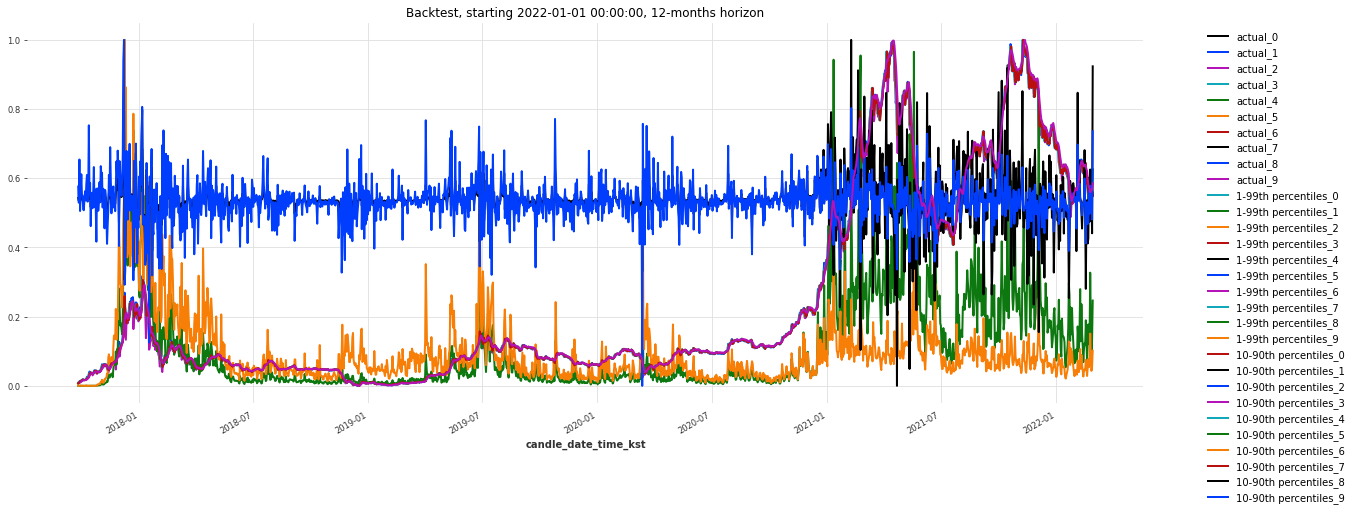

In [ ]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )


eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=series_transformed,
    horizon=forecast_horizon,
    start=training_cutoff,
    transformer=transformer,
)